In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from itertools import product
import time

In [8]:
teams = ['liverpool', 'man city', 'chelsea', 'leicester', 
         'man united', 'wolves', 'sheffield', 'tottenham', 'arsenal',
         'burnley', 'everton', 'southampton', 'newcastle', 
         'crystal palace', 'brighton', 'west ham', 'watford', 
         'bournemouth', 'aston villa', 'norwich']

team_ids = np.array(list(range(len(teams))))
name2id = dict(zip(teams, team_ids))
id2name = dict(zip(team_ids, teams))
positions = team_ids + 1

points = np.array([93, 72, 60, 59, 59, 55, 54, 52, 50, 50, 45, 45, 43, 42, 36, 34, 34, 31, 30, 21])
games_played = np.array([35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35])

g2p = [('chelsea', 'norwich'),
       ('newcastle', 'tottenham'), ('burnley', 'wolves'), ('man city', 'bournemouth'), ('arsenal', 'liverpool'),
       ('everton', 'aston villa'), ('leicester', 'sheffield'), ('southampton', 'brighton'), ('crystal palace', 'man united'),
       ('west ham', 'watford'), ('norwich', 'burnley'), ('bournemouth', 'southampton'), ('tottenham', 'leicester'),
       ('sheffield', 'everton'), ('brighton', 'newcastle'), ('wolves', 'crystal palace'),
       ('watford', 'man city'), ('aston villa', 'arsenal'), 
       ('man united', 'west ham'), ('liverpool', 'chelsea'),
       ('chelsea', 'wolves'), ('leicester', 'man united'),
       ('southampton', 'sheffield'), ('newcastle', 'liverpool'),
       ('west ham', 'aston villa'), ('burnley', 'brighton'),
       ('arsenal', 'watford'), ('man city', 'norwich'),
       ('crystal palace', 'tottenham'), ('everton', 'bournemouth')]

r2p = {36: [('chelsea', 'norwich'),
       ('newcastle', 'tottenham'), ('burnley', 'wolves'), ('man city', 'bournemouth'), ('arsenal', 'liverpool'),
       ('everton', 'aston villa'), ('leicester', 'sheffield'), ('southampton', 'brighton'), ('crystal palace', 'man united'),
       ('west ham', 'watford')], 
       37: [('norwich', 'burnley'), ('bournemouth', 'southampton'), ('tottenham', 'leicester'),
       ('sheffield', 'everton'), ('brighton', 'newcastle'), ('wolves', 'crystal palace'),
       ('watford', 'man city'), ('aston villa', 'arsenal'), 
       ('man united', 'west ham'), ('liverpool', 'chelsea')],
       38: [('chelsea', 'wolves'), ('leicester', 'man united'),
       ('southampton', 'sheffield'), ('newcastle', 'liverpool'),
       ('west ham', 'aston villa'), ('burnley', 'brighton'),
       ('arsenal', 'watford'), ('man city', 'norwich'),
       ('crystal palace', 'tottenham'), ('everton', 'bournemouth')]
      }


In [4]:
def calc_place2(tid, finishing, curr_rd, curr_played, curr_pts, curr_pos, remaining_games, max_rd=38):
    considered_games = poss_games(tid, curr_rd, remaining_games, curr_played, curr_pts, max_rd)
    if curr_rd <= max_rd:
        games_this_rd = considered_games[curr_rd]
        if len(games_this_rd) > 0:
            wdl = [0,1,2]
            tmp = np.zeros(20)
            for scenario in product(wdl, repeat=len(games_this_rd)):
                tmp *= 0
                for i, res in enumerate(scenario):
                    tid1 = name2id[games_this_rd[i][0]]
                    tid2 = name2id[games_this_rd[i][1]]
                    if res == 0:
                        tmp[tid1] += 3
                    elif res == 1:
                        tmp[tid1] += 1
                        tmp[tid2] += 1
                    else:
                        tmp[tid2] += 3
                new_rd = curr_rd + 1
                new_played = new_rd*np.ones(20)
                new_pts = curr_pts + tmp
                new_pos = ss.rankdata(-new_pts, method='min')
                calc_place2(tid, finishing, new_rd, new_played, new_pts, new_pos, considered_games, max_rd)
        else:
            num_scen_downstream = 3**(10*(max_rd - curr_rd + 1))
            finishing[curr_pos[tid]-1] += num_scen_downstream
            return
    else:
        num_scen_downstream = 3**(10*(max_rd - curr_rd + 1))
        finishing[curr_pos[tid]-1] += num_scen_downstream
        return

def game_ids(games):
    game_ids = {}
    for rd in games.keys():
        game_ids[rd] = [(name2id[g[0]], name2id[g[1]]) for g in games[rd]]

    return game_ids

def game_vectors(games):
    game_vecs = {}
    for rd in games.keys():
        game_vecs[rd] = []
        for g in games[rd]:
            tid1 = name2id[g[0]]
            tid2 = name2id[g[1]]

            win_vec = np.zeros(20)
            win_vec[tid1] = 3
            tie_vec = np.zeros(20)
            tie_vec[tid1] = 1
            tie_vec[tid2] = 1
            los_vec = np.zeros(20)
            los_vec[tid2] = 3

            all_vecs = [win_vec, tie_vec, los_vec]
            game_vecs[rd].append(all_vecs)
    
    return game_vecs

def poss_pts(tid, curr_played, curr_pts, max_rd=38):
    min_pt = curr_pts[tid]
    all_max = curr_pts + 3*(max_rd - curr_played)
    max_pt = all_max[tid]
    mask = (min_pt <= all_max) & (max_pt >= curr_pts)
    
    return mask

def thin_games(games, game_vecs, mask):
    thinned_games = [g for g in games if (mask[g[0]] or mask[g[1]])]
    thinned_vecs = [gv for g,gv in zip(games, game_vecs) if (mask[g[0]] or mask[g[1]])]

    return thinned_games, thinned_vecs

# def poss_places(tid, curr_played, curr_pts, curr_pos, max_rd=38):
#     min_pt, max_pt = poss_pts(tid, curr_played, curr_pts, max_rd)
    
#     min_pl = curr_pos[np.argmax(-1/(curr_pts - max_pt))]
#     all_max = curr_pts + 3*(max_rd - curr_played)
#     max_pl = curr_pos[np.argmax(1/(all_max - min_pt))]
    
#     return min_pl, max_pl

def poss_games(tid, curr_rd, all_games, all_game_vecs, curr_played, curr_pts, max_rd=38):
    mask = poss_pts(tid, curr_played, curr_pts, max_rd)
    games = {}
    game_vecs = {}
    for rd in all_games.keys():
        if rd >= curr_rd:
            g, gv = thin_games(all_games[rd], all_game_vecs[rd], mask)
            games[rd] = g
            game_vecs[rd] = gv

    return games, game_vecs
    

In [9]:
rvecs = game_vectors(r2p)
print(rvecs)

{36: [[array([0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 3.])], [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])], [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), array([0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])], [array([0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), array([0., 1., 0., 0., 0., 

In [25]:
def run_sims(tid, finishing, curr_rd, curr_pts, curr_pos, cons_games, cons_vecs, scen_per_outcome, max_rd=38):
    games_this_rd = cons_games[curr_rd]
    gvecs_this_rd = cons_vecs[curr_rd]
    if len(games_this_rd) > 0:
        scen_per_res = scen_per_outcome / (3**(len(games_this_rd)))
        new_rd = curr_rd + 1
        now_played = curr_rd*np.ones(20)
        for scenario in product(*gvecs_this_rd):
            new_pts = curr_pts + np.sum(scenario, axis=0)
            new_pos = np.sum(new_pts > new_pts[tid])
            if new_rd > max_rd:
                finishing[new_pos] += scen_per_res
            else:
                calc_place(tid, finishing, new_rd, now_played, new_pts, new_pos+1, cons_games, cons_vecs, max_rd)
        return 
    else:
#         if curr_pos == 2:
#             print('here!')
        finishing[curr_pos-1] += 3**(max_rd - curr_rd)
#         if curr_rd >= max_rd:
#             finishing[curr_pos] += scen_per_outcome
#         else:
#             new_rd = curr_rd + 1
#             now_played = curr_rd*np.ones(20)
#             calc_place(tid, finishing, new_rd, now_played, curr_pts, curr_pos, cons_games, cons_vecs, max_rd)
        return
        
def calc_place(tid, finishing, curr_rd, curr_played, curr_pts, curr_pos, games, game_vecs, max_rd=38):
    cons_games, cons_vecs = poss_games(tid, curr_rd, games, game_vecs, curr_played, curr_pts, max_rd)
    games_this_rd = cons_games[curr_rd]
    gvecs_this_rd = cons_vecs[curr_rd]
    if len(games_this_rd) > 0:
        opid = None
        scen_per_outcome = 3**(len(games_this_rd) - 1)
        for i, g in enumerate(games_this_rd):
            if tid == g[0]:
                opid = g[1]
                cons_games[curr_rd].remove(g)
                tid_gv = cons_vecs[curr_rd].pop(i)
                break
            elif tid == g[1]:
                opid = g[0]
                cons_games[curr_rd].remove(g)
                tid_gv = cons_vecs[curr_rd].pop(i)
                break

        if opid:
            pot_played = np.copy(curr_played)
            pot_played[tid] += 1
            pot_played[opid] += 1

            # consider win
            new_pts = curr_pts + tid_gv[0]
            g2consid, gv2consid = poss_games(tid, curr_rd, cons_games, cons_vecs, pot_played, new_pts, max_rd)
            run_sims(tid, finishing, curr_rd, new_pts, curr_pos, g2consid, gv2consid, scen_per_outcome, max_rd)

            # consider tie
            new_pts = curr_pts + tid_gv[1]
            g2consid, gv2consid  = poss_games(tid, curr_rd, cons_games, cons_vecs, pot_played, new_pts, max_rd)
            run_sims(tid, finishing, curr_rd, new_pts, curr_pos, g2consid, gv2consid, scen_per_outcome, max_rd)

            # consider loss
            new_pts = curr_pts + tid_gv[2]
            g2consid, gv2consid  = poss_games(tid, curr_rd, cons_games, cons_vecs, pot_played, new_pts, max_rd)
            run_sims(tid, finishing, curr_rd, new_pts, curr_pos, g2consid, gv2consid, scen_per_outcome, max_rd)

        else:
            run_sims(tid, finishing, curr_rd, curr_pts, curr_pos, cons_games, cons_vecs, 3*scen_per_outcome, max_rd)
    
        return 
    else:
        curr_rd += 1
        calc_place(tid, finishing, curr_rd, curr_played, curr_pts, curr_pos, cons_games, cons_vecs, max_rd)

        return 

In [7]:
rs = {35: [('watford', 'newcastle'), ('norwich', 'west ham'), ('liverpool', 'burnley'), ('sheffield', 'chelsea'), ('brighton', 'man city'),
       ('wolves', 'everton'), ('aston villa', 'crystal palace'), ('tottenham', 'arsenal'), ('bournemouth', 'leicester'),
       ('man united', 'southampton')]}


finishing = np.zeros(20)
tid = name2id['wolves']
max_rd = 35
curr_rd = games_played[tid]
poss_games(tid, curr_rd, rs, games_played, points, max_rd)
# poss_places(tid, games_played, points, positions, max_rd)


{35: [('liverpool', 'burnley'),
  ('sheffield', 'chelsea'),
  ('wolves', 'everton'),
  ('tottenham', 'arsenal')]}

Text(0.5,1,'wolves finishing after week 35')

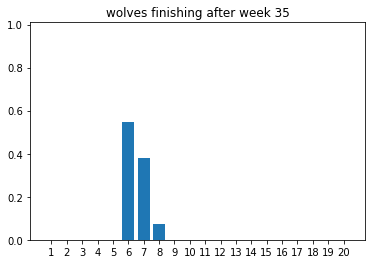

In [86]:
rs = {35: [('watford', 'newcastle'), ('norwich', 'west ham'), ('liverpool', 'burnley'), ('sheffield', 'chelsea'), ('brighton', 'man city'),
       ('wolves', 'everton'), ('aston villa', 'crystal palace'), ('tottenham', 'arsenal'), ('bournemouth', 'leicester'),
       ('man united', 'southampton')]}
rvs = game_vectors(rs)
rids = game_ids(rs)

finishing = np.zeros(20)
tid = name2id['wolves']
max_rd = 35
curr_rd = games_played[tid]+1
calc_place(tid, finishing, curr_rd, games_played, points, pos, rids, rvs, max_rd=max_rd)

plt.bar(positions, finishing / np.sum(finishing))
plt.xticks(positions);
plt.ylim([0,1.01])
plt.title('%s finishing after week %d' % (id2name[tid], max_rd))

Text(0.5,1,'arsenal finishing after week 36')

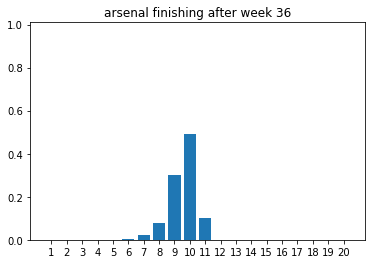

In [87]:
rs = {35: [('watford', 'newcastle'), ('norwich', 'west ham'), ('liverpool', 'burnley'), ('sheffield', 'chelsea'), ('brighton', 'man city'),
       ('wolves', 'everton'), ('aston villa', 'crystal palace'), ('tottenham', 'arsenal'), ('bournemouth', 'leicester'),
       ('man united', 'southampton')],
       36: [('chelsea', 'norwich'),
       ('newcastle', 'tottenham'), ('burnley', 'wolves'), ('man city', 'bournemouth'), ('arsenal', 'liverpool'),
       ('everton', 'aston villa'), ('leicester', 'sheffield'), ('southampton', 'brighton'), ('crystal palace', 'man united'),
       ('west ham', 'watford')]}
rvs = game_vectors(rs)
rids = game_ids(rs)

finishing = np.zeros(20)
tid = name2id['arsenal']
max_rd = 36
curr_rd = games_played[tid]+1
pos = positions[tid]
calc_place(tid, finishing, curr_rd, games_played, points, pos, rids, rvs, max_rd=max_rd)

plt.bar(positions, finishing / np.sum(finishing))
plt.xticks(positions);
plt.ylim([0,1.01])
plt.title('%s finishing after week %d' % (id2name[tid], max_rd))

In [89]:
rs = {35: [('watford', 'newcastle'), ('norwich', 'west ham'), ('liverpool', 'burnley'), ('sheffield', 'chelsea'), ('brighton', 'man city'),
       ('wolves', 'everton'), ('aston villa', 'crystal palace'), ('tottenham', 'arsenal'), ('bournemouth', 'leicester'),
       ('man united', 'southampton')],
       36: [('chelsea', 'norwich'),
       ('newcastle', 'tottenham'), ('burnley', 'wolves'), ('man city', 'bournemouth'), ('arsenal', 'liverpool'),
       ('everton', 'aston villa'), ('leicester', 'sheffield'), ('southampton', 'brighton'), ('crystal palace', 'man united'),
       ('west ham', 'watford')], 
       37: [('norwich', 'burnley'), ('bournemouth', 'southampton'), ('tottenham', 'leicester'),
       ('sheffield', 'everton'), ('brighton', 'newcastle'), ('wolves', 'crystal palace'),
       ('watford', 'man city'), ('aston villa', 'arsenal'), 
       ('man united', 'west ham'), ('liverpool', 'chelsea')]}
rvs = game_vectors(rs)
rids = game_ids(rs)

finishing = np.zeros(20)
tid = name2id['everton']
max_rd = 37
curr_rd = games_played[tid]+1
pos = positions[tid]
calc_place(tid, finishing, curr_rd, games_played, points, pos, rids, rvs, max_rd=max_rd)

plt.bar(positions, finishing / np.sum(finishing))
plt.xticks(positions);
plt.ylim([0,1.01])
plt.title('%s finishing after week %d' % (id2name[tid], max_rd))

KeyboardInterrupt: 

Text(0.5,1,'arsenal finishing after week 37')

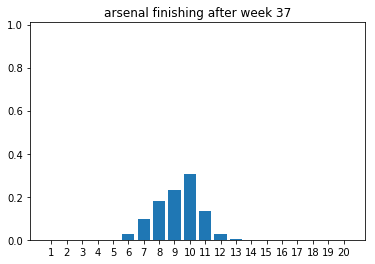

In [56]:
rs = {35: [('watford', 'newcastle'), ('norwich', 'west ham'), ('liverpool', 'burnley'), ('sheffield', 'chelsea'), ('brighton', 'man city'),
       ('wolves', 'everton'), ('aston villa', 'crystal palace'), ('tottenham', 'arsenal'), ('bournemouth', 'leicester'),
       ('man united', 'southampton')],
       36: [('chelsea', 'norwich'),
       ('newcastle', 'tottenham'), ('burnley', 'wolves'), ('man city', 'bournemouth'), ('arsenal', 'liverpool'),
       ('everton', 'aston villa'), ('leicester', 'sheffield'), ('southampton', 'brighton'), ('crystal palace', 'man united'),
       ('west ham', 'watford')], 
       37: [('norwich', 'burnley'), ('bournemouth', 'southampton'), ('tottenham', 'leicester'),
       ('sheffield', 'everton'), ('brighton', 'newcastle'), ('wolves', 'crystal palace'),
       ('watford', 'man city'), ('aston villa', 'arsenal'), 
       ('man united', 'west ham'), ('liverpool', 'chelsea')]}
rvs = game_vectors(rs)

finishing = np.zeros(20)
tid = name2id['arsenal']
max_rd = 37
curr_rd = games_played[tid] + 1
calc_place(tid, finishing, curr_rd, games_played, points, positions, rs, rvs, max_rd=max_rd)

plt.bar(positions, finishing / np.sum(finishing))
plt.xticks(positions);
plt.ylim([0,1.01])
plt.title('%s finishing after week %d' % (id2name[tid], max_rd))

In [52]:
rs = {35: [('watford', 'newcastle'), ('norwich', 'west ham'), ('liverpool', 'burnley'), ('sheffield', 'chelsea'), ('brighton', 'man city'),
       ('wolves', 'everton'), ('aston villa', 'crystal palace'), ('tottenham', 'arsenal'), ('bournemouth', 'leicester'),
       ('man united', 'southampton')],
       36: [('chelsea', 'norwich'),
       ('newcastle', 'tottenham'), ('burnley', 'wolves'), ('man city', 'bournemouth'), ('arsenal', 'liverpool'),
       ('everton', 'aston villa'), ('leicester', 'sheffield'), ('southampton', 'brighton'), ('crystal palace', 'man united'),
       ('west ham', 'watford')]}

rvs = game_vectors(rs)

max_rd = 36
F = np.zeros((20,20))
for i, team in enumerate(teams):
    finishing = np.zeros(20)
    tid = name2id[team]
    curr_rd = games_played[tid]+1
    calc_place(tid, finishing, curr_rd, games_played, points, positions, rs, rvs, max_rd=max_rd)
    F[i,:] = finishing
    print('Done with', team)

Done with liverpool
Done with man city
Done with chelsea
Done with leicester
Done with man united
Done with wolves
Done with sheffield
Done with arsenal
Done with tottenham
Done with burnley
Done with everton
Done with southampton
Done with newcastle
Done with crystal palace
Done with brighton
Done with west ham
Done with watford
Done with aston villa
Done with bournemouth
Done with norwich


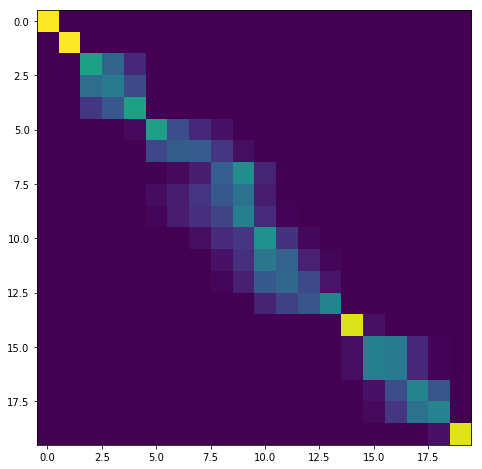

In [53]:
row_sums = F.sum(axis=1)
Fnorm = F / row_sums[:, np.newaxis]

plt.figure(figsize=(8,8))
plt.imshow(Fnorm)

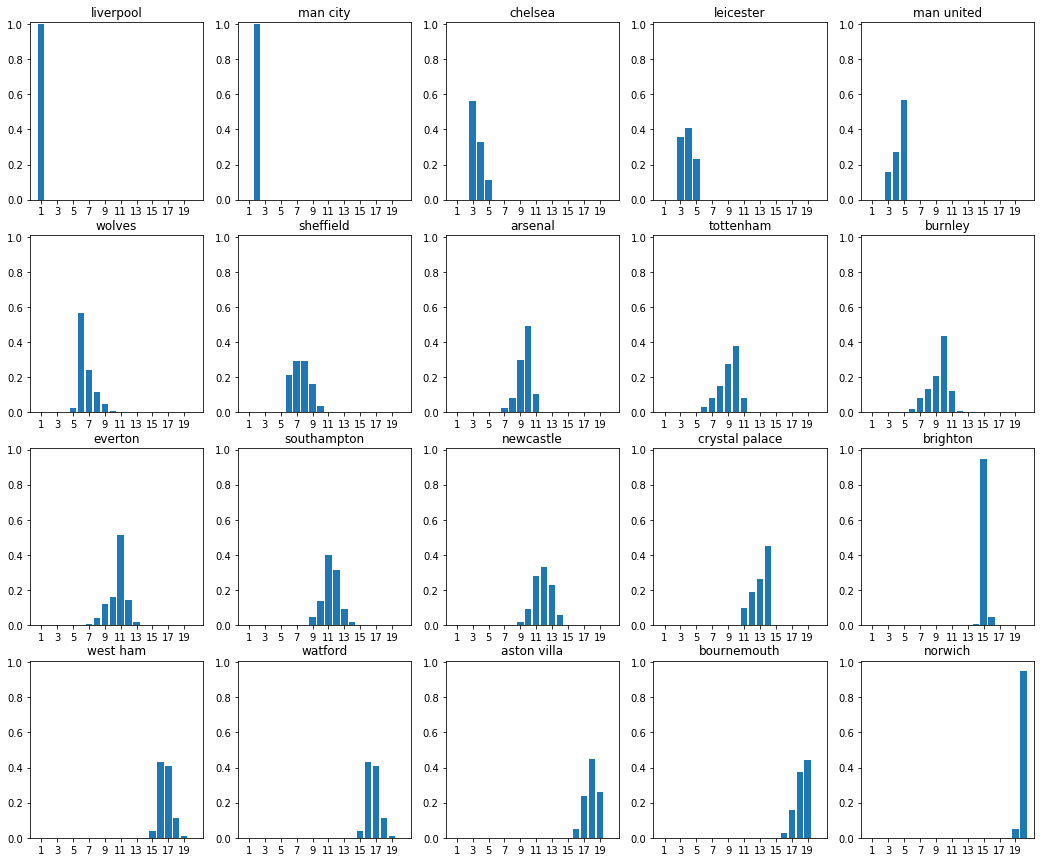

In [54]:
plt.figure(figsize=(18,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.bar(positions, Fnorm[i,:])
    plt.xticks(positions[::2]);
    plt.ylim([0,1.01])
    plt.title('%s' % id2name[i])

In [26]:
start = time.time()
max_rd = 38
F2 = np.zeros((20,20))
rvecs = game_vectors(r2p)
r2pids = game_ids(r2p)
for tid in range(20):
    finishing = np.zeros(20)
    curr_rd = games_played[tid]+1
    pos = positions[tid]
    calc_place(tid, finishing, curr_rd, games_played, points, pos, r2pids, rvecs, max_rd=max_rd)
    F2[tid,:] = finishing
    print('Done with', id2name[tid])

end = time.time()
print(end - start)

Done with liverpool
Done with man city
Done with chelsea
Done with leicester
Done with man united
Done with wolves
Done with sheffield
Done with tottenham
Done with arsenal
Done with burnley
Done with everton
Done with southampton
Done with newcastle
Done with crystal palace
Done with brighton
Done with west ham
Done with watford
Done with bournemouth
Done with aston villa
Done with norwich
5536.801113128662


Text(0.5,1,'chelsea finishing after week 38')

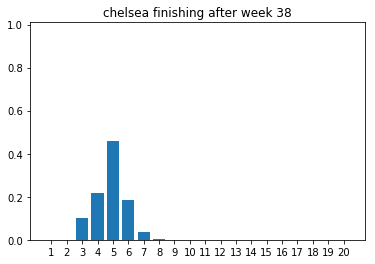

In [75]:
plt.bar(positions, finishing / np.sum(finishing))
plt.xticks(positions);
plt.ylim([0,1.01])
plt.title('%s finishing after week %d' % (id2name[2], max_rd))

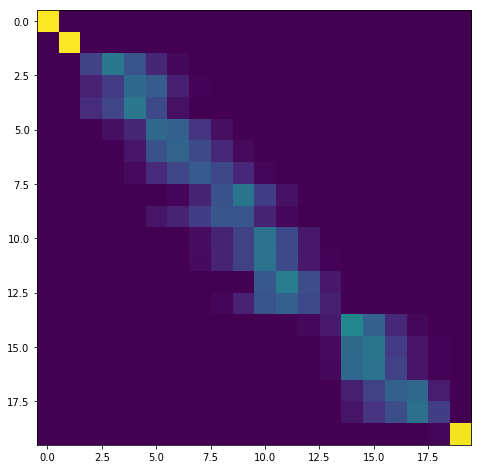

In [27]:
row_sums = F2.sum(axis=1)
Fnorm = F2 / row_sums[:, np.newaxis]

plt.figure(figsize=(8,8))
plt.imshow(Fnorm)

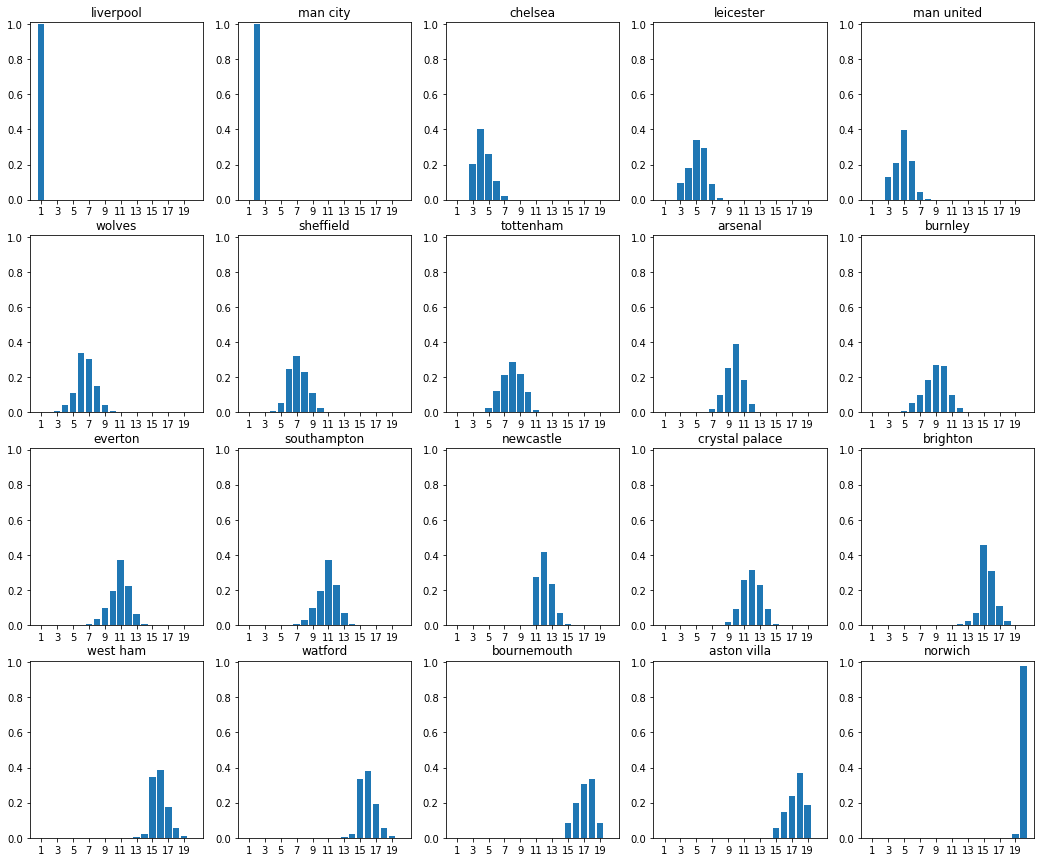

In [28]:
plt.figure(figsize=(18,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.bar(positions, Fnorm[i,:])
    plt.xticks(positions[::2]);
    plt.ylim([0,1.01])
    plt.title('%s' % id2name[i])

In [23]:
finishing = np.zeros(20)
tid = name2id['chelsea']
max_rd = 38
curr_rd = games_played[tid] + 1
calc_place(tid, finishing, curr_rd, games_played, points, positions, r2pids, rvecs, max_rd=max_rd)

In [24]:
finishing

array([    0.,     0., 49550., 97684., 62993., 25789.,  4923.,   160.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.])

In [240]:
def calc_points(curr_pts, finish, gamez):
    tid1 = name2id[gamez[0][0]]
    tid2 = name2id[gamez[0][1]]
    win_pts = np.copy(curr_pts)
    win_pts[tid1] += 3
    
    tie_pts = np.copy(curr_pts)
    tie_pts[tid1] += 1
    tie_pts[tid2] += 1
    
    lose_pts = np.copy(curr_pts)
    lose_pts[tid2] += 3
    if len(gamez) > 1:
        calc_points(win_pts, finish, gamez[1:])
        calc_points(tie_pts, finish, gamez[1:])
        calc_points(lose_pts, finish, gamez[1:])
    else:
        win_pos = np.argsort(-win_pts)
        tie_pos = np.argsort(-tie_pts)
        lose_pos = np.argsort(-lose_pts)
        for i in range(20):
            finish[i, win_pos[i]] += 1
            finish[i, tie_pos[i]] += 1
            finish[i, lose_pos[i]] += 1
                    
        return
    
def calc(points, finish, games):
    wdl = [0,1,2]
    tmp = np.zeros(20)
    ct = 0
    for scenario in product(wdl, repeat=len(games)):
        ct += 1
        tmp *= 0
        for i, res in enumerate(scenario):
            tid1 = name2id[games[i][0]]
            tid2 = name2id[games[i][1]]
            if res == 0:
                tmp[tid1] += 3
            elif res == 1:
                tmp[tid1] += 1
                tmp[tid2] += 1
            else:
                tmp[tid2] += 3
        
        posis = ss.rankdata(-(points+tmp))-1
        for i in range(20):
            finish[i, int(posis[i])] += 1

    return finish

def calc_team(tid, points, all_games, max_games):
    wdl = [0, 1, 2]
    finish = np.zeros(20)
    tmp = np.zeros(20)
#     t_games = games_that_matter(tid, all_games, max_games=max_games)
    t_games = all_games
    for scenario in product(wdl, repeat=len(t_games)):
        tmp *= 0
        for i, res in enumerate(scenario):
            tid1 = name2id[t_games[i][0]]
            tid2 = name2id[t_games[i][1]]
            if res == 0:
                tmp[tid1] += 3
            elif res == 1:
                tmp[tid1] += 1
                tmp[tid2] += 1
            else:
                tmp[tid2] += 3
        new_pts = points + tmp
        new_pos = np.sum(new_pts > new_pts[tid])
        finish[new_pos] += 1
    
    return finish